In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
import seaborn as sns

In [3]:
import gensim

In [4]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Conv1D, MaxPool1D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam


In [ ]:
'''nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')'''

In [5]:
data = pd.read_csv("/content/drive/MyDrive/dataset.csv")

In [7]:
import pandas as pd

# Assuming df is your DataFrame and 'label_column' is the name of the column containing the labels
count_label_0 = data['label'].value_counts().get(0, 0)
print("Number of fake news:", count_label_0)


Number of fake news: 28782


In [8]:
import pandas as pd

# Assuming df is your DataFrame and 'label_column' is the name of the column containing the labels
count_label_1 = data['label'].value_counts().get(1, 1)
print("Number of true news", count_label_1)


Number of true news 26460


In [9]:
len(data)

55242

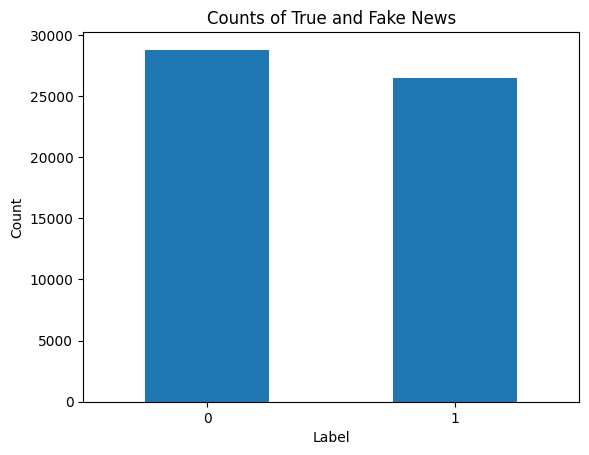

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'label_column' is the name of the column containing the labels
counts = data['label'].value_counts()

# Plotting the counts in a bar graph
counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Counts of True and Fake News')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()


In [11]:
data['content'] = data['content'].apply(lambda x: str(x).lower())

In [12]:
data.head()

,content,label
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0


In [13]:
#Removing special characters
data['content'] = data['content'].astype(str)
data['content'] = data['content'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))


In [14]:
data.head()

,content,label
0,donald trump sends out embarrassing new years...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obamas name ...,0
4,pope francis just called out donald trump dur...,0


In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#Remove stopwords
stop_word = set(stopwords.words('english'))
data['content'] = data['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_word]))

In [ ]:
'''#Remove stopwords
stop_word = set(stopwords.words('english'))
data['content'] = data['content'].apply(lambda x: [word for word in x if word not in stop_word])'''

In [ ]:
data.head()

In [17]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
#lemmatization
lemmatizer = WordNetLemmatizer()
data['content'] = data['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

#shuffle rows
data = data.sample(frac=1)

In [ ]:
data.head()

,content,label
10622,trump obsession ww general strike sour note hi...,1
23793,senate plan september hearing health insurance...,0
10767,american want obama nominate scalias replaceme...,1
28668,bannon role trump administration set critical ...,0
52535,fantasy better iran deal insisting better deal...,1


Word2Vec vectorization

In [22]:
#Convert label into an array. y is a target variable
y = data['label'].values
x = [d.split() for d in data['content'].tolist()]



In [23]:
dim = 300       #dimension of vector after vectorization

w2v_model = gensim.models.Word2Vec(sentences=x, vector_size=dim, window=10, min_count=1)

In [ ]:
#Check the no of unique words in vocabulary
len(w2v_model.wv)

234945

In [25]:
#find most similar word
w2v_model.wv.most_similar('nepal')

[('kathmandu', 0.7305843234062195),
 ('djibouti', 0.6838981509208679),
 ('nepali', 0.6738329529762268),
 ('ethiopia', 0.6368119716644287),
 ('barbuda', 0.6358087658882141),
 ('antigua', 0.6291499733924866),
 ('typhoon', 0.6274178624153137),
 ('neighbouring', 0.6240174174308777),
 ('nigeria', 0.6230722069740295),
 ('earthquake', 0.6105775833129883)]

Feed vectors from w2v_model as initial weights to lstm and it again recreates the vector. This improves accuracy

In [24]:
#convert into sequence of texts

tokenizer = Tokenizer()

tokenizer.fit_on_texts(x)       #Assigns unique integer index to each unique word in text

In [26]:
#convert into sequence of numbers
x = tokenizer.texts_to_sequences(x)

In [27]:
#Check sequence for a word
tokenizer.word_index

{'trump': 1,
 'said': 2,
 'u': 3,
 'state': 4,
 'would': 5,
 'president': 6,
 'people': 7,
 'one': 8,
 'republican': 9,
 'clinton': 10,
 'year': 11,
 'new': 12,
 'also': 13,
 'time': 14,
 'say': 15,
 'government': 16,
 'house': 17,
 'obama': 18,
 'donald': 19,
 'like': 20,
 'could': 21,
 'american': 22,
 'country': 23,
 'campaign': 24,
 'election': 25,
 'party': 26,
 'reuters': 27,
 'white': 28,
 'told': 29,
 'united': 30,
 'two': 31,
 'right': 32,
 'news': 33,
 'last': 34,
 'first': 35,
 'official': 36,
 'hillary': 37,
 'make': 38,
 'even': 39,
 'get': 40,
 'day': 41,
 'group': 42,
 'many': 43,
 'week': 44,
 'law': 45,
 'former': 46,
 'may': 47,
 'vote': 48,
 'washington': 49,
 'want': 50,
 'political': 51,
 'video': 52,
 'national': 53,
 'medium': 54,
 'woman': 55,
 'way': 56,
 'going': 57,
 'know': 58,
 'back': 59,
 'court': 60,
 'think': 61,
 'security': 62,
 'take': 63,
 'police': 64,
 'made': 65,
 'democrat': 66,
 'percent': 67,
 'million': 68,
 'world': 69,
 'since': 70,
 'suppo

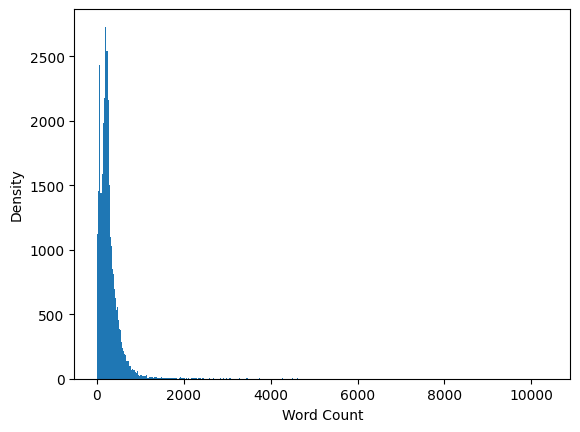

In [28]:
#Show histogram of total no of words in the news
plt.hist([len(a) for a in x], bins = 700)
#plt.show()
#import matplotlib.pyplot as plt

# Assuming x contains the tokenized words of one column of your dataset

#plt.hist([len(a) for a in x], bins=700)
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.show()


In [ ]:
#calculate news that have more than 1000 words
nos = np.array([len(a) for a in x])
print(len(nos[nos>2000]))

103


In [ ]:
max_length = 2000
x = pad_sequences(x, maxlen=max_length)          #padding the sequences

In [ ]:
len(x[0])

In [ ]:
#Determine vocabulary size
vocab_size = 160_00
vocab = tokenizer.word_index

In [ ]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, dim))

  for word, i in vocab.items():
    if i < weight_matrix.shape[0]:
      weight_matrix[i] = model.wv[word]

  return weight_matrix



In [ ]:
embedding_vector = get_weight_matrix(w2v_model)

In [ ]:
embedding_vector.shape

(16000, 300)